<a href="https://colab.research.google.com/github/swilsonmfc/notebooks/blob/master/NeuralNetworksEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks & Embeddings

# Setup

In [3]:
pip install gensim

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import math

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
tf.__version__

'2.2.0'

# Kaggle

In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [9]:
!kaggle datasets download -d jpayne/852k-used-car-listings

 88% 40.0M/45.2M [00:01<00:00, 10.0MB/s]
100% 45.2M/45.2M [00:02<00:00, 21.9MB/s]


In [0]:
# Unzip quietly
!unzip -q /content/852k-used-car-listings.zip

In [11]:
ls -al /content

total 189556
drwxr-xr-x 1 root root     4096 Jun  4 03:12 ./
drwxr-xr-x 1 root root     4096 Jun  4 03:08 ../
-rw-r--r-- 1 root root 47402340 Jun  4 03:12 852k-used-car-listings.zip
drwxr-xr-x 1 root root     4096 Jun  2 16:14 .config/
drwxr-xr-x 1 root root     4096 May 29 18:19 sample_data/
-rw-r--r-- 1 root root 90391630 Sep 21  2019 tc20171021.csv
-rw-r--r-- 1 root root 56287873 Sep 21  2019 true_car_listings.csv


In [12]:
df = pd.read_csv('/content/true_car_listings.csv')
df.shape

(852122, 8)

# EDA

In [13]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


## Missing
* No missing data

In [14]:
df.isna().sum(axis=0)

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

## Price
* A few expensive cars in the dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdbde08358>]],
      dtype=object)

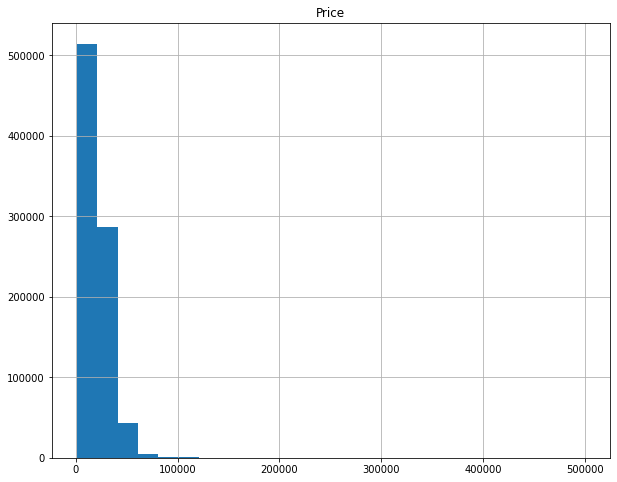

In [15]:
df.hist('Price', bins=25, figsize=(10,8))

In [16]:
df[df.Price > 100000].sort_values('Price', ascending=False)

,Price,Year,Mileage,City,State,Vin,Make,Model
622265,499500,2014,3260,Westville,NJ,WDDRJ7HA4EA010693,Mercedes-Benz,SLS
622264,490000,2008,3307,Encino,CA,WDDAK76F78M001594,Mercedes-Benz,SLR
549574,469991,2016,312,Saint James,NY,ZHWUR1ZD5GLA05118,Lamborghini,Aventador2dr
480444,469973,2016,6525,Kirkland,WA,SAJBK4BV2GCY19895,Jaguar,XF35t
549573,462000,2017,261,Davie,FL,ZHWUC1ZD4HLA05825,Lamborghini,AventadorCoupe
...,...,...,...,...,...,...,...,...
703751,100900,2015,10951,West Palm Beach,FL,WP0CB2A99FS143302,Porsche,911Cabriolet
621927,100880,2016,4887,Silver Spring,MD,WDDXJ8FB6GA012974,Mercedes-Benz,S-ClassS550
621920,100855,2017,12,Hagerstown,MD,WDDUG8FB0HA321455,Mercedes-Benz,S-ClassS
553583,100777,2016,11665,Houston,TX,SALWZ2EF0GA589511,Land,Rover


https://www.auto.com/cars/mercedes_benz-sls_amg_black_series-base-2014-wddrj7ha4ea010693

## Mileage

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdbde382e8>]],
      dtype=object)

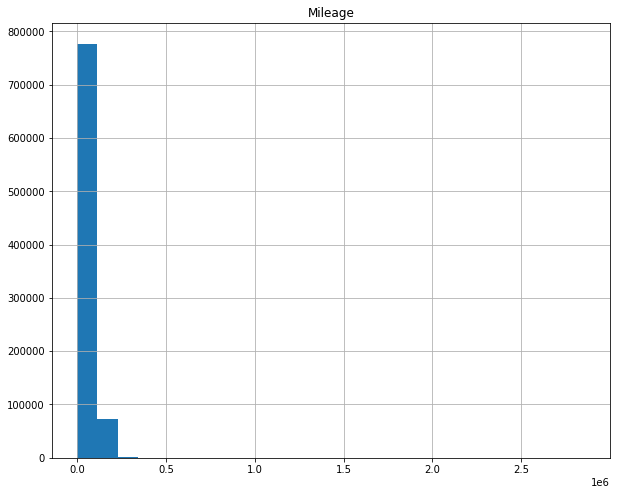

In [17]:
df.hist('Mileage', bins=25, figsize=(10,8))

In [18]:
df[df.Mileage > 100000].sort_values('Mileage', ascending=False)

,Price,Year,Mileage,City,State,Vin,Make,Model
186465,4933,2002,2856196,Hayward,CA,3GNFK16T32G206964,Chevrolet,Suburban4dr
186464,13686,2013,2457832,Columbus,GA,1GCNCPEX1DZ185639,Chevrolet,Silverado
478168,4990,2005,2137327,Schaumburg,IL,JNRAS08W85X203448,INFINITI,FX35AWD
429123,4995,2006,1814638,Philadelphia,PA,1HGFA16826L131367,Honda,Civic
349757,5991,2010,1650780,Fort Lauderdale,FL,1FMEU6EE5AUA07808,Ford,ExplorerRWD
...,...,...,...,...,...,...,...,...
444279,9495,2012,100001,Arlington,TX,KMHEC4A49CA057345,Hyundai,Sonata4dr
828544,6499,2013,100001,Vienna,VA,3VW2K7AJ1DM317823,Volkswagen,Jetta
275776,5988,2003,100001,Boise,ID,1FMYU93193KE17086,Ford,Escape4dr
354845,13385,2012,100001,Alachua,FL,1GKKRRED5CJ116425,GMC,AcadiaFWD


https://www.carstory.com/detail/2002-chevrolet-suburban_1500-hayward_ca-3GNFK16T32G206964

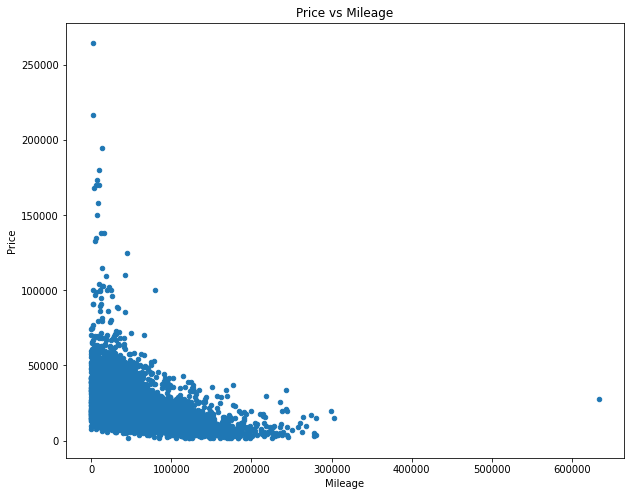

In [23]:
df.sample(10000).plot('Mileage', 'Price', kind='scatter', figsize=(10,8))
plt.title('Price vs Mileage');

## Year

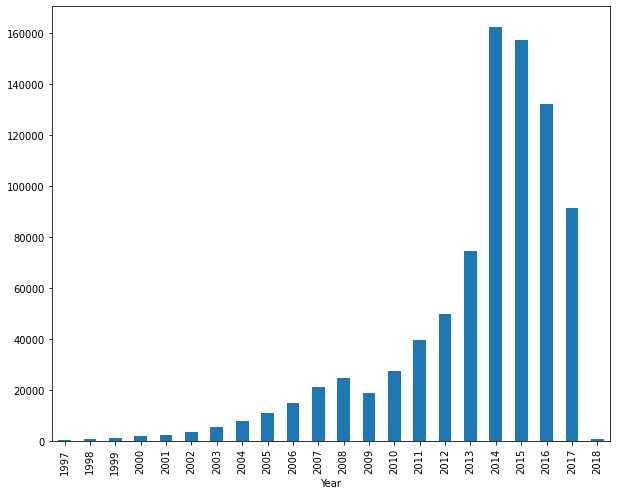

In [18]:
df.groupby('Year').size().plot(kind='bar', figsize=(10,8))

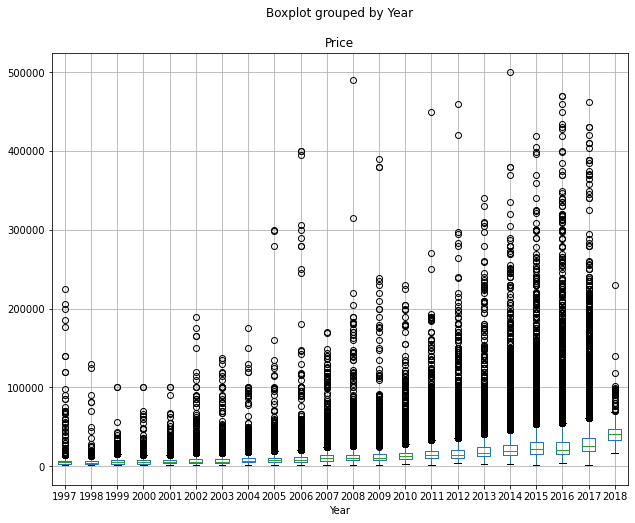

In [39]:
df.boxplot('Price', by='Year', figsize=(10,8));

## City

In [19]:
len(df.City.unique())

2553

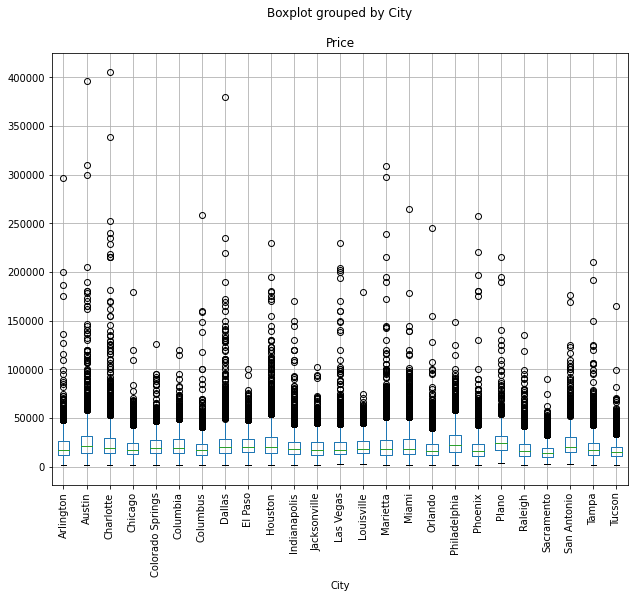

In [37]:
sub = df.groupby('City').size().sort_values(ascending=False).head(25)
df[df.City.isin(sub.index)].boxplot('Price', by='City', figsize=(10,8))
plt.xticks(rotation=90);

## State
* Mixed cases on states result in duplicates

In [20]:
len(df.State.unique())

59

In [21]:
df.State.unique()

array([' TX', ' NY', ' CO', ' UT', ' FL', ' CT', ' ID', ' ND', ' CA',
       ' NJ', ' OH', ' VA', ' IN', ' AZ', ' OR', ' KS', ' NE', ' MA',
       ' MD', ' GA', ' MN', ' HI', ' LA', ' NM', ' IL', ' AL', ' PA',
       ' SC', ' NC', ' WA', ' WI', ' OK', ' KY', ' MS', ' MO', ' ME',
       ' AR', ' MI', ' NV', ' TN', ' Fl', ' NH', ' DE', ' WV', ' Az',
       ' VT', ' SD', ' IA', ' RI', ' ga', ' Oh', ' MT', ' DC', ' AK',
       ' Va', ' WY', ' Md', ' Ca', ' Ga'], dtype=object)

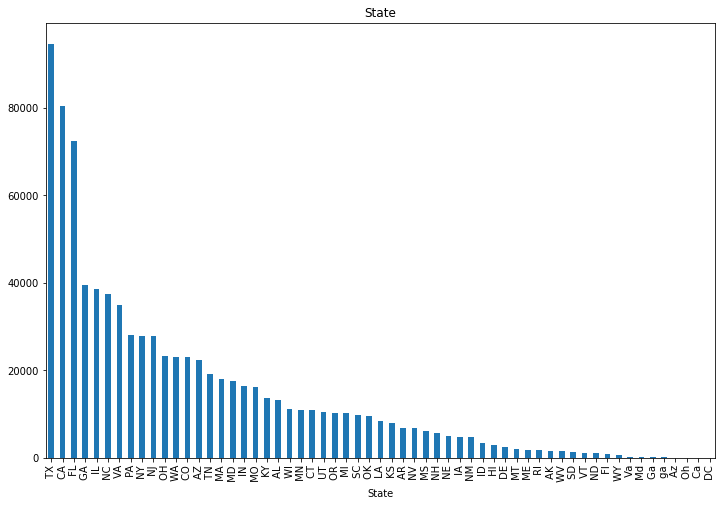

In [22]:
df.groupby('State') \
.size() \
.sort_values(ascending=False) \
.plot(kind='bar', figsize=(12,8))
plt.title('State');

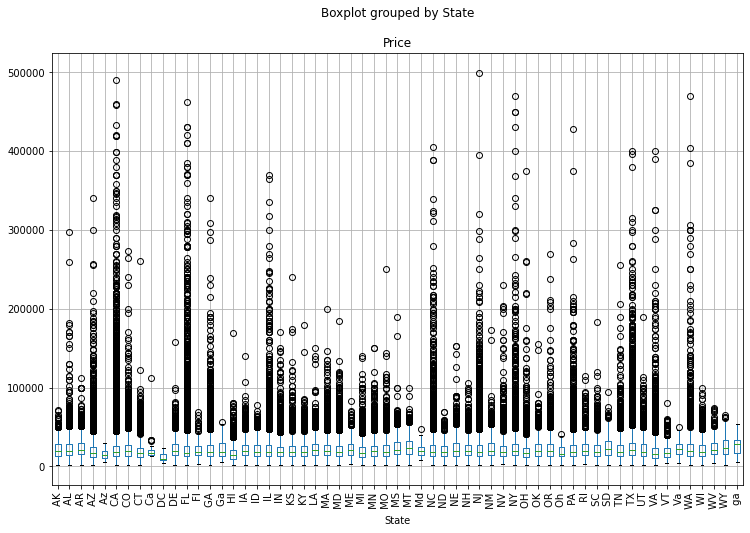

In [27]:
df.boxplot('Price', by='State', figsize=(12,8))
plt.xticks(rotation=90);

## VIN
* Vehicle identification number
* Unique per vehicle

In [23]:
len(df.Vin.unique())

852075

## Make

In [0]:
df['Make'] = df['Make'].astype('category')

In [25]:
df.Make.unique()

[Acura, Alfa, AM, Aston, Audi, ..., Suzuki, Tesla, Toyota, Volkswagen, Volvo]
Length: 58
Categories (58, object): [Acura, Alfa, AM, Aston, ..., Tesla, Toyota, Volkswagen, Volvo]

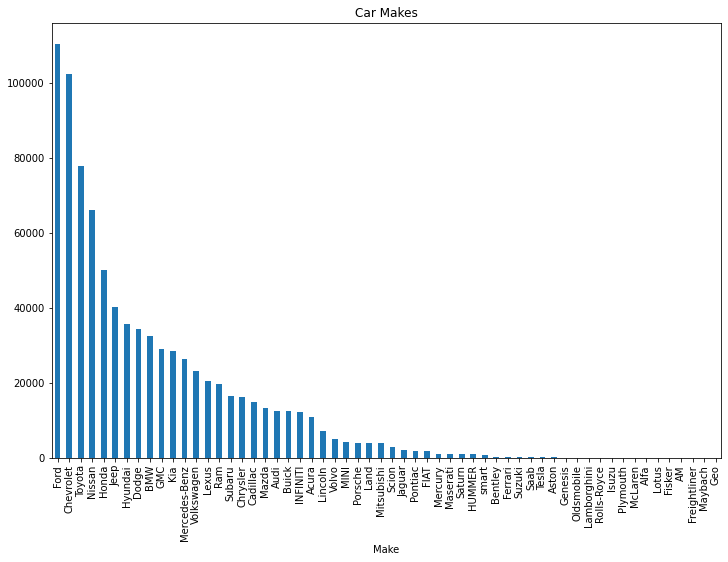

In [26]:
df.groupby('Make') \
.size() \
.sort_values(ascending=False) \
.plot(kind='bar', figsize=(12,8))
plt.title('Car Makes');

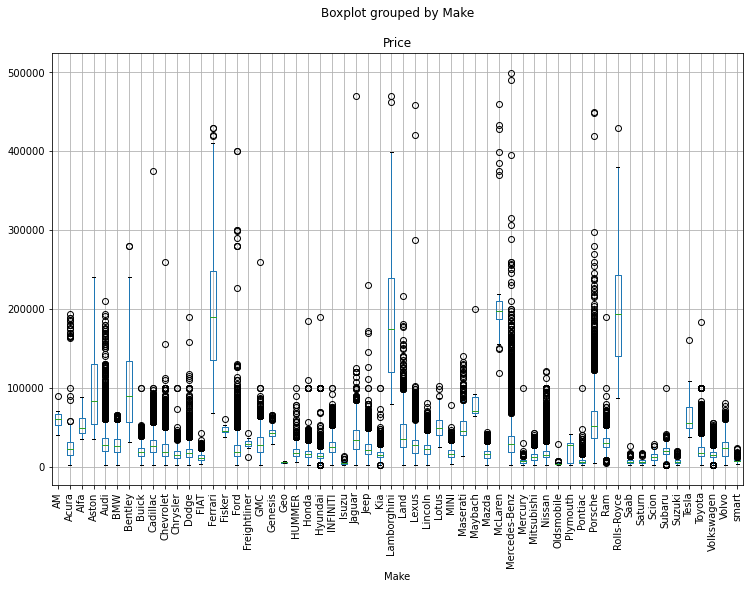

In [26]:
df.boxplot('Price', by='Make', figsize=(12,8))
plt.xticks(rotation=90);

## Model

In [28]:
df.groupby('Model').size().sort_values()

Model
S4Prestige           1
CenturyCustom        1
CenturyCUSTOM        1
Celica2dr            1
S60Sedan             1
                 ...  
Altima2.5        11288
F-1504WD         14177
Accord           14502
Grand            17321
Silverado        24932
Length: 2736, dtype: int64

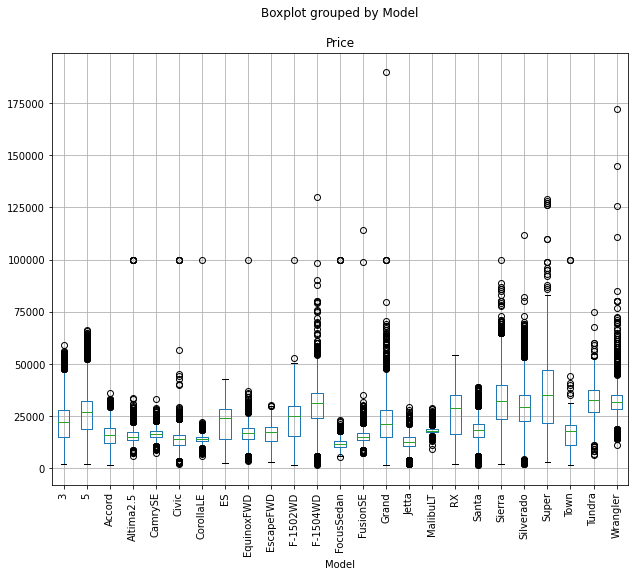

In [33]:
sub = df.groupby('Model').size().sort_values(ascending=False).head(25)
df[df.Model.isin(sub.index)].boxplot('Price', by='Model', figsize=(10,8))
plt.xticks(rotation=90);

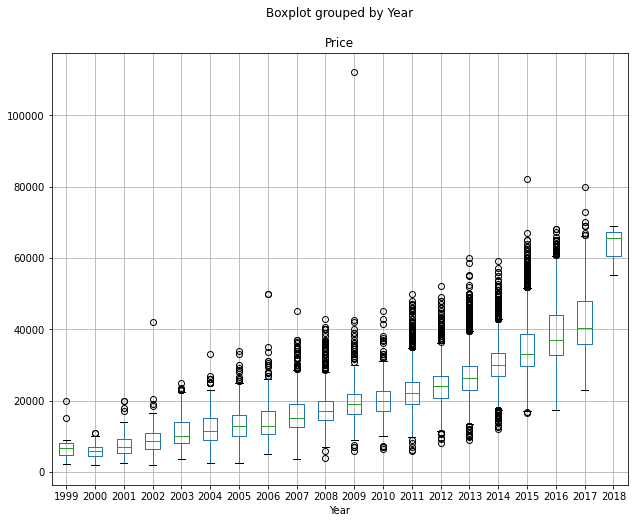

In [34]:
sub = df[df.Model == 'Silverado'].boxplot('Price', by='Year', figsize=(10,8))

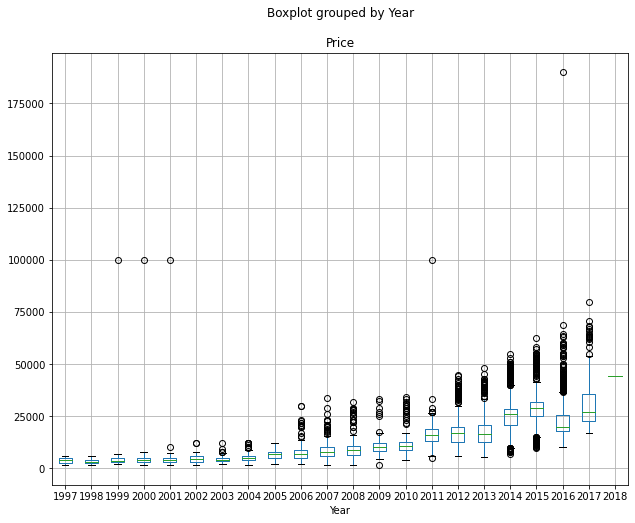

In [35]:
sub = df[df.Model == 'Grand'].boxplot('Price', by='Year', figsize=(10,8))

# Helpers

In [0]:
def plot_performance(history, color_train='blue', color_val='red'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation MAE')
    plt.ylabel('MAE')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Comparison

In [0]:
results_df = pd.DataFrame(columns=['MAE', 'RMSE'])

# Parameters

In [0]:
batch_size = 1024
epochs = 50

# Shallow

## Features

In [0]:
X = df.copy()
y = X['Price']
X['Age'] = 2017 - X.Year
X['State'] = X.State.str.upper()

In [0]:
X = pd.concat([X, pd.get_dummies(X.Make, prefix='Make')], axis=1)
X = pd.concat([X, pd.get_dummies(X.State, prefix='State')], axis=1)

In [0]:
X = X.drop('Price', axis=1)
X = X.drop('Vin', axis=1)
X = X.drop('Make', axis=1)
X = X.drop('Model', axis=1)
X = X.drop('State', axis=1)
X = X.drop('City', axis=1)

In [260]:
X.head()

,Year,Mileage,Age,Make_AM,Make_Acura,Make_Alfa,Make_Aston,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Fisker,Make_Ford,Make_Freightliner,Make_GMC,Make_Genesis,Make_Geo,Make_HUMMER,Make_Honda,Make_Hyundai,Make_INFINITI,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land,Make_Lexus,Make_Lincoln,Make_Lotus,Make_MINI,Make_Maserati,Make_Maybach,Make_Mazda,...,State_ HI,State_ IA,State_ ID,State_ IL,State_ IN,State_ KS,State_ KY,State_ LA,State_ MA,State_ MD,State_ ME,State_ MI,State_ MN,State_ MO,State_ MS,State_ MT,State_ NC,State_ ND,State_ NE,State_ NH,State_ NJ,State_ NM,State_ NV,State_ NY,State_ OH,State_ OK,State_ OR,State_ PA,State_ RI,State_ SC,State_ SD,State_ TN,State_ TX,State_ UT,State_ VA,State_ VT,State_ WA,State_ WI,State_ WV,State_ WY
0,2014,35725,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2013,19606,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,48851,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2014,39922,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,22142,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Train / Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8877)
input_shape = (X.shape[1], )

## Model

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_shape)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [263]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 256)               28928     
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 257       
Total params: 29,185
Trainable params: 29,185
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=3e-4),
              metrics=['mae', 'mse'])

## Train

In [265]:
history_shallow = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/50
675/675 [==============================] - 2s 3ms/step - loss: 393718080.0000 - mae: 14347.4072 - mse: 393718080.0000 - val_loss: 257417248.0000 - val_mae: 10328.9473 - val_mse: 257417248.0000
Epoch 2/50
675/675 [==============================] - 2s 3ms/step - loss: 191051696.0000 - mae: 8642.6074 - mse: 191051696.0000 - val_loss: 156880736.0000 - val_mae: 7729.4385 - val_mse: 156880736.0000
Epoch 3/50
675/675 [==============================] - 2s 3ms/step - loss: 155037312.0000 - mae: 7970.8608 - mse: 155037312.0000 - val_loss: 150615680.0000 - val_mae: 7782.6948 - val_mse: 150615680.0000
Epoch 4/50
675/675 [==============================] - 2s 3ms/step - loss: 150675248.0000 - mae: 7887.6460 - mse: 150675248.0000 - val_loss: 148927232.0000 - val_mae: 7739.8257 - val_mse: 148927232.0000
Epoch 5/50
675/675 [==============================] - 2s 4ms/step - loss: 148873408.0000 - mae: 7841.2007 - mse: 148873408.0000 - val_loss: 148176864.0000 - val_mae: 7709.5728 - val_mse: 148

## Test

In [266]:
pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')

results_df.loc['Shallow'] = [mae, rmse]

MAE  : 7,099.89
RMSE : 11,343.47


## Plots

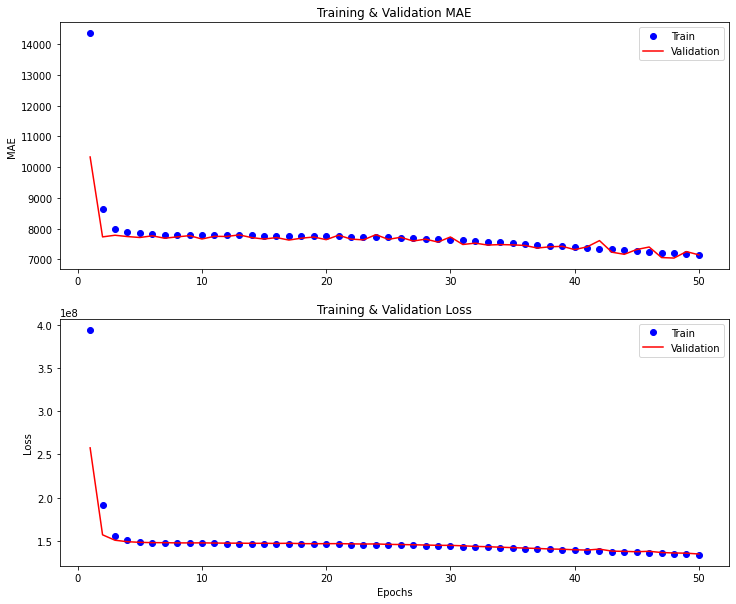

In [267]:
plot_performance(history_shallow)

# Deep

## Features
* Drop VIN
* One Hot Categorical
* Year -> Age

In [0]:
X = df.copy()
y = X['Price']
X['Age'] = 2017 - X.Year
X['State'] = X.State.str.upper()

In [0]:
X = pd.concat([X, pd.get_dummies(X.Make, prefix='Make')], axis=1)
X = pd.concat([X, pd.get_dummies(X.State, prefix='State')], axis=1)

In [0]:
X = X.drop('Price', axis=1)
X = X.drop('Vin', axis=1)
X = X.drop('Make', axis=1)
X = X.drop('Model', axis=1)
X = X.drop('State', axis=1)
X = X.drop('City', axis=1)

In [271]:
X.head()

,Year,Mileage,Age,Make_AM,Make_Acura,Make_Alfa,Make_Aston,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Fisker,Make_Ford,Make_Freightliner,Make_GMC,Make_Genesis,Make_Geo,Make_HUMMER,Make_Honda,Make_Hyundai,Make_INFINITI,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land,Make_Lexus,Make_Lincoln,Make_Lotus,Make_MINI,Make_Maserati,Make_Maybach,Make_Mazda,...,State_ HI,State_ IA,State_ ID,State_ IL,State_ IN,State_ KS,State_ KY,State_ LA,State_ MA,State_ MD,State_ ME,State_ MI,State_ MN,State_ MO,State_ MS,State_ MT,State_ NC,State_ ND,State_ NE,State_ NH,State_ NJ,State_ NM,State_ NV,State_ NY,State_ OH,State_ OK,State_ OR,State_ PA,State_ RI,State_ SC,State_ SD,State_ TN,State_ TX,State_ UT,State_ VA,State_ VT,State_ WA,State_ WI,State_ WV,State_ WY
0,2014,35725,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2013,19606,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,48851,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2014,39922,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,22142,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Train / Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8877)
input_shape = (X.shape[1], )

## Model

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_shape)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [274]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               28928     
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                

In [0]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=3e-4),
              metrics=['mae', 'mse'])

## Train

In [276]:
history_baseline = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/50
675/675 [==============================] - 2s 3ms/step - loss: 217435248.0000 - mae: 9735.5420 - mse: 217435248.0000 - val_loss: 152879264.0000 - val_mae: 7845.2910 - val_mse: 152879264.0000
Epoch 2/50
675/675 [==============================] - 2s 3ms/step - loss: 154272048.0000 - mae: 8011.0913 - mse: 154272048.0000 - val_loss: 152453600.0000 - val_mae: 7701.3735 - val_mse: 152453600.0000
Epoch 3/50
675/675 [==============================] - 2s 3ms/step - loss: 152526496.0000 - mae: 7946.6694 - mse: 152526496.0000 - val_loss: 147544080.0000 - val_mae: 7776.4194 - val_mse: 147544080.0000
Epoch 4/50
675/675 [==============================] - 2s 3ms/step - loss: 151565440.0000 - mae: 7916.7437 - mse: 151565440.0000 - val_loss: 147591360.0000 - val_mae: 7640.2534 - val_mse: 147591360.0000
Epoch 5/50
675/675 [==============================] - 2s 3ms/step - loss: 151346208.0000 - mae: 7901.2861 - mse: 151346208.0000 - val_loss: 147570480.0000 - val_mae: 7850.2251 - val_mse: 14757

## Test

In [277]:
pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')

results_df.loc['Deep'] = [mae, rmse]

MAE  : 6,012.63
RMSE : 9,750.62


## Plots

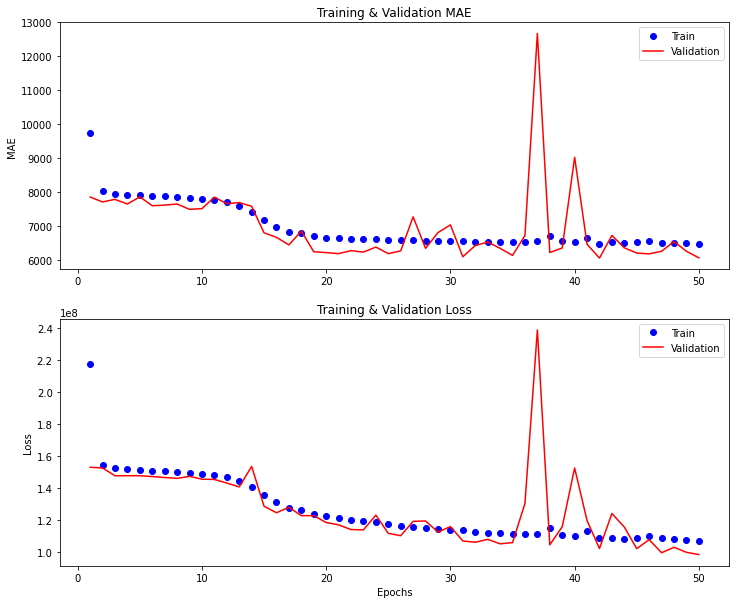

In [278]:
plot_performance(history_baseline)

# VIN Model
![VIN](https://static.wixstatic.com/media/c859a6_1a14ee4056084072b103984bea14b7bf~mv2.jpg/v1/fill/w_626,h_418/c859a6_1a14ee4056084072b103984bea14b7bf~mv2.jpg)

## Features

In [0]:
X = df.copy()
y = X['Price']
X['Age'] = 2017 - X.Year
X['State'] = X.State.str.upper()

In [280]:
X['Serial'] = X.Vin.str[-6:]
X['Location'] = X.Vin.str[0:1]
X['Manufacturer'] = X.Vin.str[1:2]
X['VehicleType'] = X.Vin.str[2:3]
X['Description'] = X.Vin.str[4:9]
X.head()

,Price,Year,Mileage,City,State,Vin,Make,Model,Age,Serial,Location,Manufacturer,VehicleType,Description
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed,3,000083,1,9,V,E2E53
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed,4,012636,1,9,V,E1F52
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed,4,000025,1,9,V,E2E52
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed,3,003817,1,9,V,E1F71
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic,1,001284,1,9,U,E2F32


In [0]:
X = pd.concat([X, pd.get_dummies(X.Make, prefix='Make')], axis=1)
X = pd.concat([X, pd.get_dummies(X.State, prefix='State')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Location, prefix='Location')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Manufacturer, prefix='Manufacturer')], axis=1)
X = pd.concat([X, pd.get_dummies(X.VehicleType, prefix='VehicleType')], axis=1)

In [0]:
X = X.drop('Price', axis=1)
X = X.drop('Vin', axis=1)
X = X.drop('Serial', axis=1)
X = X.drop('Location', axis=1)
X = X.drop('Manufacturer', axis=1)
X = X.drop('VehicleType', axis=1)
X = X.drop('Description', axis=1)
X = X.drop('Make', axis=1)
X = X.drop('Model', axis=1)
X = X.drop('State', axis=1)
X = X.drop('City', axis=1)

In [283]:
X.head()

,Year,Mileage,Age,Make_AM,Make_Acura,Make_Alfa,Make_Aston,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Fisker,Make_Ford,Make_Freightliner,Make_GMC,Make_Genesis,Make_Geo,Make_HUMMER,Make_Honda,Make_Hyundai,Make_INFINITI,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land,Make_Lexus,Make_Lincoln,Make_Lotus,Make_MINI,Make_Maserati,Make_Maybach,Make_Mazda,...,Manufacturer_T,Manufacturer_U,Manufacturer_V,Manufacturer_X,Manufacturer_Y,Manufacturer_Z,VehicleType_,VehicleType_0,VehicleType_1,VehicleType_2,VehicleType_3,VehicleType_4,VehicleType_5,VehicleType_6,VehicleType_7,VehicleType_8,VehicleType_9,VehicleType_A,VehicleType_B,VehicleType_C,VehicleType_D,VehicleType_E,VehicleType_F,VehicleType_G,VehicleType_H,VehicleType_J,VehicleType_K,VehicleType_L,VehicleType_M,VehicleType_N,VehicleType_P,VehicleType_R,VehicleType_S,VehicleType_T,VehicleType_U,VehicleType_V,VehicleType_W,VehicleType_X,VehicleType_Y,VehicleType_Z
0,2014,35725,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2013,19606,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2013,48851,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2014,39922,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016,22142,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [284]:
X.shape

(852122, 198)

## Train / Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8877)
input_shape = (X.shape[1], )

## Model

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [287]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               50944     
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                

In [0]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=3e-4),
              metrics=['mae', 'mse'])

## Train

In [289]:
history_vin = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/50
675/675 [==============================] - 3s 4ms/step - loss: 228417344.0000 - mae: 10030.2314 - mse: 228417344.0000 - val_loss: 154910096.0000 - val_mae: 7905.2905 - val_mse: 154910096.0000
Epoch 2/50
675/675 [==============================] - 3s 4ms/step - loss: 155428752.0000 - mae: 8042.2295 - mse: 155428752.0000 - val_loss: 147938464.0000 - val_mae: 7692.1816 - val_mse: 147938464.0000
Epoch 3/50
675/675 [==============================] - 2s 4ms/step - loss: 153350944.0000 - mae: 7956.3867 - mse: 153350944.0000 - val_loss: 147059376.0000 - val_mae: 7633.5117 - val_mse: 147059376.0000
Epoch 4/50
675/675 [==============================] - 2s 4ms/step - loss: 152015760.0000 - mae: 7907.4839 - mse: 152015760.0000 - val_loss: 145986448.0000 - val_mae: 7670.1846 - val_mse: 145986448.0000
Epoch 5/50
675/675 [==============================] - 2s 4ms/step - loss: 150752176.0000 - mae: 7866.2749 - mse: 150752176.0000 - val_loss: 145025152.0000 - val_mae: 7561.0205 - val_mse: 1450

## Test

In [290]:
pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')

results_df.loc['VIN'] = [mae, rmse]

MAE  : 5,300.68
RMSE : 8,853.23


## Plots

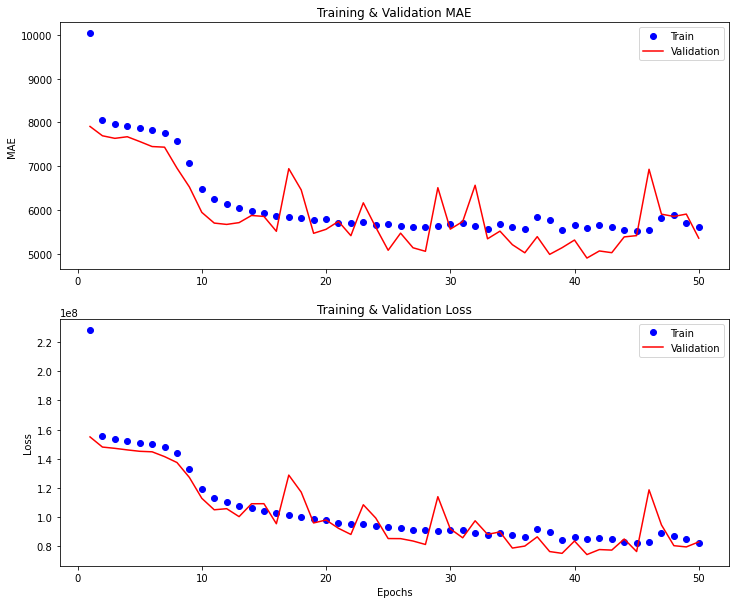

In [291]:
plot_performance(history_vin)

# Target Encoding

## Features

In [0]:
X = df.copy()
y = X['Price']
X['Age'] = 2017 - X.Year
X['State'] = X.State.str.upper()

In [0]:
means_df = X.groupby('Model')['Price'].mean()
means_df.reset_index()
means_df.columns = ['Model', 'Price']
X = pd.merge(X, means_df, left_on='Model', right_on='Model')
X = df.rename(columns={'Price_x': 'Price', 'Price_y':'Model_Target'})

In [336]:
X['Serial'] = X.Vin.str[-6:]
X['Location'] = X.Vin.str[0:1]
X['Manufacturer'] = X.Vin.str[1:2]
X['VehicleType'] = X.Vin.str[2:3]
X['Description'] = X.Vin.str[4:9]
X.head()

,Price,Year,Mileage,City,State,Vin,Make,Model,Serial,Location,Manufacturer,VehicleType,Description
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed,000083,1,9,V,E2E53
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed,012636,1,9,V,E1F52
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed,000025,1,9,V,E2E52
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed,003817,1,9,V,E1F71
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic,001284,1,9,U,E2F32


In [0]:
X = pd.concat([X, pd.get_dummies(X.Make, prefix='Make')], axis=1)
X = pd.concat([X, pd.get_dummies(X.State, prefix='State')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Location, prefix='Location')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Manufacturer, prefix='Manufacturer')], axis=1)
X = pd.concat([X, pd.get_dummies(X.VehicleType, prefix='VehicleType')], axis=1)

In [0]:
X = X.drop('Price', axis=1)
X = X.drop('Vin', axis=1)
X = X.drop('Serial', axis=1)
X = X.drop('Location', axis=1)
X = X.drop('Manufacturer', axis=1)
X = X.drop('VehicleType', axis=1)
X = X.drop('Description', axis=1)
X = X.drop('Make', axis=1)
X = X.drop('Model', axis=1)
X = X.drop('State', axis=1)
X = X.drop('City', axis=1)

In [339]:
X.shape

(852122, 205)

## Train / Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8877)
input_shape = (X.shape[1], )

## Model

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [342]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 256)               52736     
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_67 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)               

In [0]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=3e-4),
              metrics=['mae', 'mse'])

## Train

In [344]:
history_target = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/50
675/675 [==============================] - 3s 4ms/step - loss: 233125536.0000 - mae: 10142.7715 - mse: 233125536.0000 - val_loss: 151541648.0000 - val_mae: 7721.0718 - val_mse: 151541648.0000
Epoch 2/50
675/675 [==============================] - 2s 4ms/step - loss: 155403168.0000 - mae: 8038.9004 - mse: 155403168.0000 - val_loss: 151885328.0000 - val_mae: 7669.3872 - val_mse: 151885328.0000
Epoch 3/50
675/675 [==============================] - 3s 4ms/step - loss: 153381872.0000 - mae: 7964.0586 - mse: 153381872.0000 - val_loss: 147836272.0000 - val_mae: 7576.1167 - val_mse: 147836272.0000
Epoch 4/50
675/675 [==============================] - 3s 4ms/step - loss: 152559952.0000 - mae: 7929.1768 - mse: 152559952.0000 - val_loss: 147261040.0000 - val_mae: 7577.0298 - val_mse: 147261040.0000
Epoch 5/50
675/675 [==============================] - 3s 4ms/step - loss: 151828144.0000 - mae: 7895.3579 - mse: 151828144.0000 - val_loss: 149182560.0000 - val_mae: 7480.5679 - val_mse: 1491

## Test

In [345]:
pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')

results_df.loc['Target Encoding'] = [mae, rmse]

MAE  : 5,756.63
RMSE : 9,217.41


## Plots

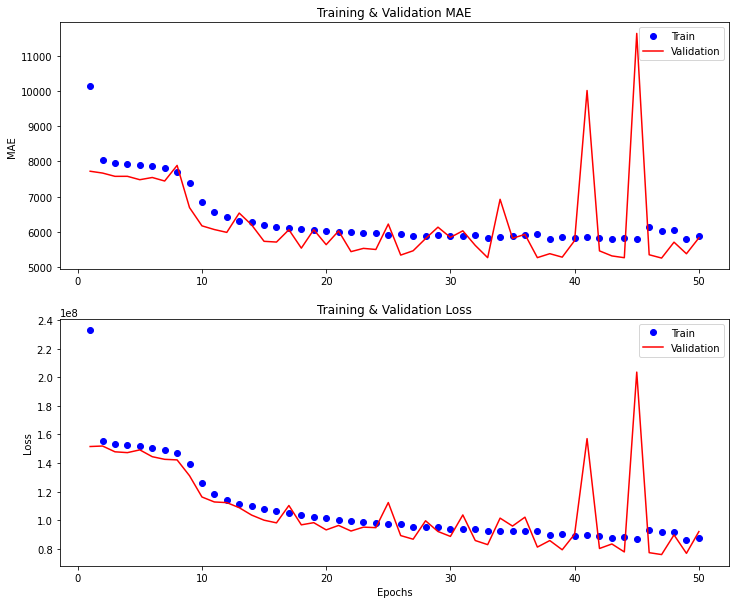

In [346]:
plot_performance(history_target)

# Sequential vs Functional

## Model

In [0]:
inputs = keras.Input(shape=input_shape, name="input")
x = Dense(256, activation="relu")(inputs)
x = Dropout(.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(.2)(x)
outputs = Dense(1, activation="linear")(x)
model = Model(inputs, outputs, name="auto_prices")

# Embedding Model

## Features

In [0]:
X = df.copy()
y = X['Price']
X['Age'] = 2017 - X.Year
X['State'] = X.State.str.upper()

In [0]:
means_df = X.groupby('Model')['Price'].mean()
means_df.reset_index()
means_df.columns = ['Model', 'Price']
X = pd.merge(X, means_df, left_on='Model', right_on='Model')
X = X.rename(columns={'Price_x': 'Price', 'Price_y':'Model_Target'})

In [0]:
X['Serial'] = X.Vin.str[-6:]
X['Location'] = X.Vin.str[0:1]
X['Manufacturer'] = X.Vin.str[1:2]
X['VehicleType'] = X.Vin.str[2:3]
X['Description'] = X.Vin.str[4:9]

In [0]:
X = pd.concat([X, pd.get_dummies(X.Make, prefix='Make')], axis=1)
X = pd.concat([X, pd.get_dummies(X.State, prefix='State')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Location, prefix='Location')], axis=1)
X = pd.concat([X, pd.get_dummies(X.Manufacturer, prefix='Manufacturer')], axis=1)
X = pd.concat([X, pd.get_dummies(X.VehicleType, prefix='VehicleType')], axis=1)

In [314]:
len(X.Description.unique())

68509

In [0]:
X = X.drop('Price', axis=1)
X = X.drop('Vin', axis=1)
X = X.drop('Serial', axis=1)
X = X.drop('Location', axis=1)
X = X.drop('Manufacturer', axis=1)
X = X.drop('VehicleType', axis=1)
X = X.drop('Description', axis=1)
X = X.drop('Make', axis=1)
X = X.drop('Model', axis=1)
X = X.drop('State', axis=1)
X = X.drop('City', axis=1)

In [316]:
X.shape

(852122, 199)

## Train / Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=8877)

In [0]:
def col_split(col_prefix, X_train, X_test):
  cols = X_train.columns[X_train.columns.str.startswith(col_prefix)]
  X_train_split = X_train[cols]
  X_test_split  = X_test[cols]
  X_train = X_train.drop(cols, axis=1)
  X_test  = X_test.drop(cols, axis=1)
  return X_train_split, X_test_split, X_train, X_test

X_train_make,         X_test_make,         X_train, X_test = col_split('Make_', X_train, X_test)
X_train_state,        X_test_state,        X_train, X_test = col_split('State_', X_train, X_test)
X_train_location,     X_test_location,     X_train, X_test = col_split('Location_', X_train, X_test)
X_train_manufacturer, X_test_manufacturer, X_train, X_test = col_split('Manufacturer_', X_train, X_test)
X_train_vehicletype,  X_test_vehicletype,  X_train, X_test = col_split('VehicleType_', X_train, X_test)

In [0]:
def input_embedding_size(inputs):
  input_size = inputs.shape[1]
  embed_size = min(50, (inputs.shape[1] // 2) + 1)
  return input_size, embed_size

input_size                                     = X_train.shape[1]
input_size_make,         emb_size_make         = input_embedding_size(X_train_make)
input_size_state,        emb_size_state        = input_embedding_size(X_train_state)
input_size_location,     emb_size_location     = input_embedding_size(X_train_location)
input_size_manufacturer, emb_size_manufacturer = input_embedding_size(X_train_manufacturer)
input_size_vehicletype,  emb_size_vehicletype  = input_embedding_size(X_train_vehicletype)

In [320]:
print('Input',        X_train.shape)
print('Make',         X_train_make.shape)
print('State',        X_train_state.shape)
print('Location',     X_train_location.shape)
print('Manufacturer', X_train_manufacturer.shape)
print('VehicleType',  X_train_vehicletype.shape)

Input (766909, 4)
Make (766909, 58)
State (766909, 51)
Location (766909, 23)
Manufacturer (766909, 29)
VehicleType (766909, 34)


In [321]:
X_train.head()


,Year,Mileage,Age,Model_Target
720142,2016,32984,1,42470.486655
457667,2011,82225,6,10173.097996
629890,2016,32415,1,11734.747433
163757,2010,102004,7,22869.067609
289751,2011,74108,6,18038.827107


## Model

In [0]:
inputs = keras.Input(shape=(input_size,), name='inputs')

inputs_make = keras.Input(shape=(input_size_make,), name='inputs_make')
x_make = Embedding(input_dim=input_size_make, output_dim = emb_size_make)(inputs_make)
x_make = Flatten()(x_make)

inputs_state = keras.Input(shape=(input_size_state,), name='inputs_state')
x_state = Embedding(input_dim=input_size_state, output_dim = emb_size_state)(inputs_state)
x_state = Flatten()(x_state)

inputs_location = keras.Input(shape=(input_size_location,), name='inputs_location')
x_location = Embedding(input_dim=input_size_location, output_dim = emb_size_location)(inputs_location)
x_location = Flatten()(x_location)

inputs_manufacturer = keras.Input(shape=(input_size_manufacturer,), name='inputs_manufacturer')
x_manufacturer = Embedding(input_dim=input_size_manufacturer, output_dim = emb_size_manufacturer)(inputs_manufacturer)
x_manufacturer = Flatten()(x_manufacturer)

inputs_vehicletype = keras.Input(shape=(input_size_vehicletype,), name='inputs_vehicletype')
x_vehicletype = Embedding(input_dim=input_size_vehicletype, output_dim = emb_size_vehicletype)(inputs_vehicletype)
x_vehicletype = Flatten()(x_vehicletype)

x = Concatenate(axis=1)([inputs, x_make, x_state, x_location, x_manufacturer, x_vehicletype])
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(.2)(x)
outputs = Dense(1, activation='linear')(x)

model = keras.Model(
    inputs=[inputs, inputs_make, inputs_state, inputs_location, inputs_manufacturer, inputs_vehicletype],
    outputs=[outputs],
    name='auto_prices'
)

In [323]:
model.summary()

Model: "auto_prices"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_make (InputLayer)        [(None, 58)]         0                                            
__________________________________________________________________________________________________
inputs_state (InputLayer)       [(None, 51)]         0                                            
__________________________________________________________________________________________________
inputs_location (InputLayer)    [(None, 23)]         0                                            
__________________________________________________________________________________________________
inputs_manufacturer (InputLayer [(None, 29)]         0                                            
________________________________________________________________________________________

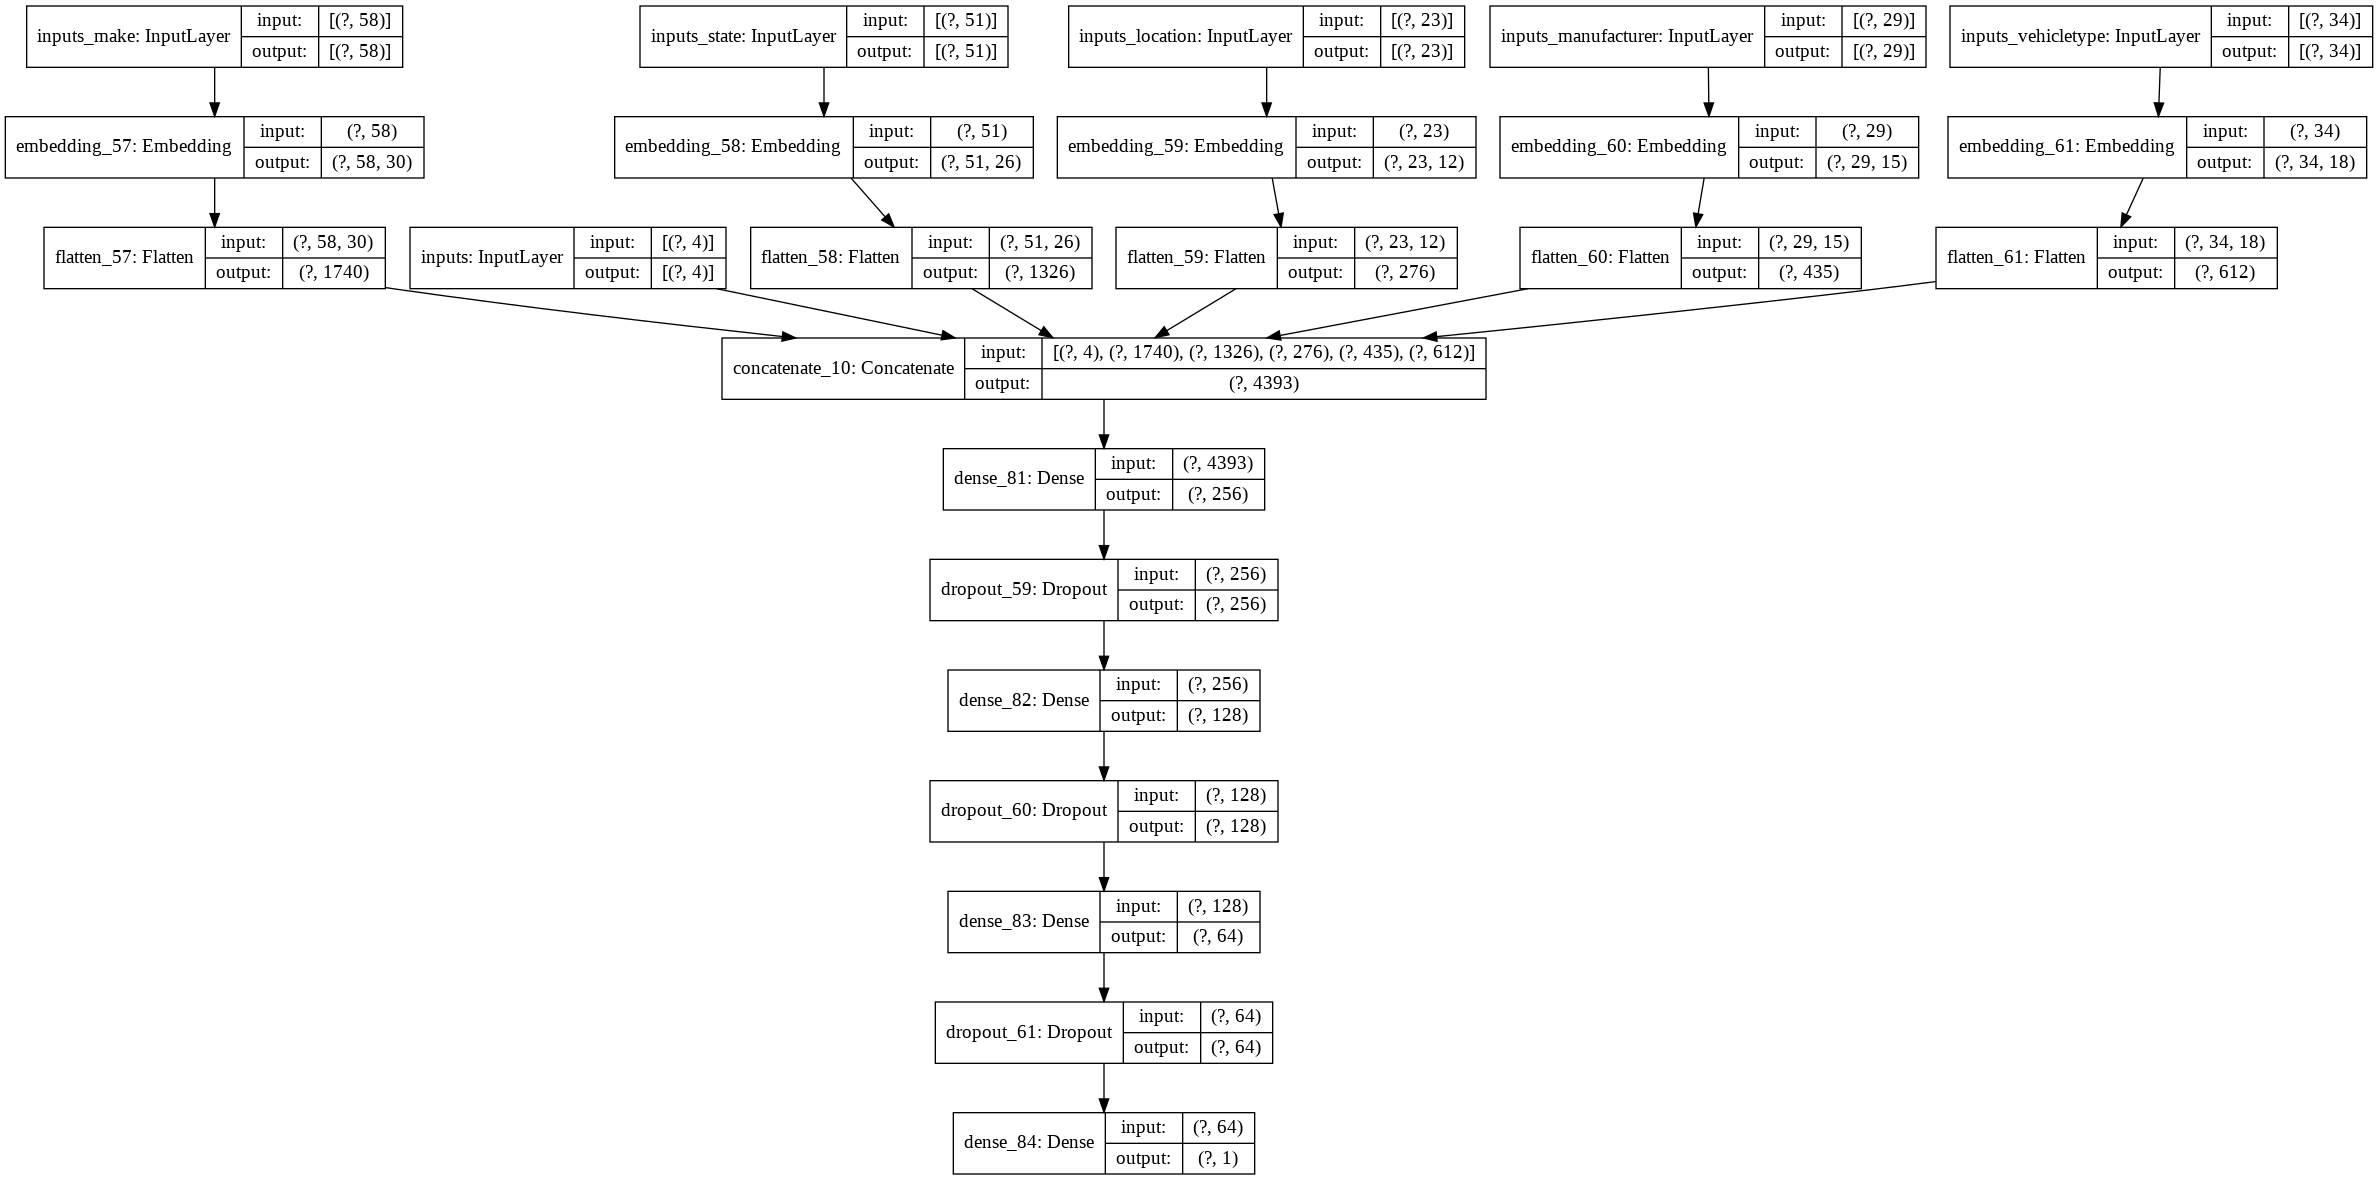

In [324]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=3e-4),
              metrics=['mae', 'mse'])

## Train

In [326]:
history_embedding = model.fit({'inputs':X_train, 
                                'inputs_make':X_train_make,
                                'inputs_state':X_train_state,
                                'inputs_location':X_train_location,
                                'inputs_manufacturer':X_train_manufacturer,
                                'inputs_vehicletype':X_train_vehicletype}, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/50
675/675 [==============================] - 11s 16ms/step - loss: 191198688.0000 - mae: 8985.7119 - mse: 191198688.0000 - val_loss: 159044544.0000 - val_mae: 8059.5947 - val_mse: 159044544.0000
Epoch 2/50
675/675 [==============================] - 10s 15ms/step - loss: 163291424.0000 - mae: 8281.1240 - mse: 163291424.0000 - val_loss: 156746320.0000 - val_mae: 7999.6577 - val_mse: 156746320.0000
Epoch 3/50
675/675 [==============================] - 10s 15ms/step - loss: 161190096.0000 - mae: 8227.9209 - mse: 161190096.0000 - val_loss: 156809024.0000 - val_mae: 8092.7949 - val_mse: 156809024.0000
Epoch 4/50
675/675 [==============================] - 11s 16ms/step - loss: 159404208.0000 - mae: 8176.5625 - mse: 159404208.0000 - val_loss: 154549264.0000 - val_mae: 7936.8696 - val_mse: 154549264.0000
Epoch 5/50
675/675 [==============================] - 10s 15ms/step - loss: 158725456.0000 - mae: 8155.9497 - mse: 158725456.0000 - val_loss: 153462784.0000 - val_mae: 7937.7114 - val_

## Test

In [327]:
pred = model.predict({'inputs':X_test, 
                      'inputs_make':X_test_make,
                      'inputs_state':X_test_state,
                      'inputs_location':X_test_location,
                      'inputs_manufacturer':X_test_manufacturer,
                      'inputs_vehicletype':X_test_vehicletype})

mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')

results_df.loc['Embedding'] = [mae, rmse]

MAE  : 6,608.34
RMSE : 10,477.71


## Plots

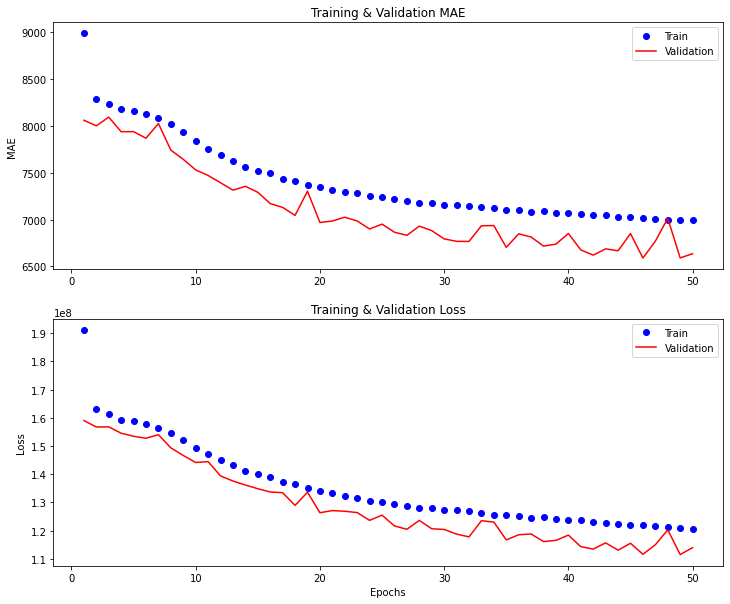

In [328]:
plot_performance(history_embedding)

# Results

In [329]:
results_df

,MAE,RMSE
Shallow,7099.885389,11343.465522
Deep,6012.633080,9750.624218
VIN,5300.682613,8853.229538
Target Encoding,5254.847035,8715.380848
Embedding,6608.343565,10477.711398
